# Example: Using the Parallel LazyESN

This tutorial shows how to use the [LazyESN](generated/xesn.LazyESN.rst) class, covering:

- preparing the ``esn_chunks``, ``overlap``, and ``boundary`` information, defining the network of ESNs

- building and training the network

- making sample predictions and comparing the predictions to test data

- storing the network weights and re-reading the network to a LazyESN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use("./xesn.mplstyle")

## Create training and testing data

Here we generate a time series using the 36 Dimensional version of the Lorenz 96 model
<cite data-cite="lorenz_predictability_1996">(Lorenz 1996)</cite>.

We do this in a similar fashion as in 
the [Standard ESN Tutorial](example_esn_usage.ipynb#Create-training-and-testing-data).

In [3]:
from lorenz import Lorenz96

In [4]:
model = Lorenz96(N=36)

In [5]:
n_spinup = 20_000
n_train = 40_000
n_transient = 1_000
n_test = 1_000

n_total = n_spinup+n_train+n_transient+n_test

rs = np.random.RandomState(0)
x0 = np.zeros(model.N)
x0[0]=0.01
trajectory = model.generate(n_steps=n_total, x0=x0)#, x0=rs.normal(size=(model.N,)))

In [6]:
trainer = trajectory.isel(time=slice(n_spinup,n_spinup+n_train+1))
tester = trajectory.isel(time=slice(-n_test-1, None))

In [7]:
bias = trainer.mean()
scale = trainer.std()

In [8]:
trainer = (trainer - bias)/scale
tester = (tester - bias)/scale

## Set the ESN Chunk Size, Overlap Size, and Boundary

Here, make each single chunk the same size as one of the ESNs in the [Standard ESN Tutorial](example_esn_usage.ipynb#Create-the-ESN).

In [9]:
# with a single spatial dimension, this is simple to define
esn_chunks = {"x": 6}

**Overlap**

As shown by <cite data-cite="platt_systematic_2022">(Platt et al., 2022)</cite>,
a parallel ESN emulator for the Lorenz96 system
requires an overlap of at least 2 in the spatial dimension in order to have enough 
information to make a decent prediction.

In [10]:
overlap = {"x": 2}

**Boundary**

The Lorenz96 system is periodic in it's only "spatial" (or non-time) dimension, so this is easy to set

In [11]:
boundary = "periodic"
# or equally
# boundary = {"x": "periodic"}

## Create the LazyESN

As an example, we choose parameters other than those discussed above to be the same as in the
[Standard ESN Tutorial](example_esn_usage.ipynb#Create-the-ESN),
given that each individual chunk is the same size as the entire system in that example.

In [12]:
from xesn import LazyESN

In [13]:
esn = LazyESN(
    esn_chunks=esn_chunks,
    overlap=overlap,
    boundary=boundary,
    persist=True,
    n_reservoir=500,
    leak_rate=0.87,
    tikhonov_parameter=6.9e-7,
    input_kwargs={
        "factor": 0.86,
        "normalization": "svd",
        "distribution": "uniform",
        "random_seed": 0,
    },
    adjacency_kwargs={
        "factor":0.71,
        "normalization": "eig",
        "distribution": "uniform",
        "is_sparse": True,
        "connectedness": 5,
        "random_seed": 1,
    },
    bias_kwargs={
        "factor": 1.8,
        "distribution": "uniform",
        "random_seed": 2,
    },
)

In [14]:
esn

LazyESN
    input_chunks:
        x                   10
        time                -1
---
    output_chunks:
        x                   6
        time                -1
---
    overlap:
        x                   2
        time                0
---
    boundary:               periodic
---
    n_input:                10
    n_output:               6
    n_reservoir:            500
---
    leak_rate:              0.87
    tikhonov_parameter:     6.9e-07
---
    Input Matrix:
        factor              0.86
        normalization       svd
        distribution        uniform
        random_seed         0
---
    Adjacency Matrix:
        factor              0.71
        normalization       eig
        distribution        uniform
        is_sparse           True
        connectedness       5
        random_seed         1
---
    Bias Vector:
        factor              1.8
        distribution        uniform
        random_seed         2

<div class="alert alert-info">
    
**Note**: LazyESN computes ``n_input`` and ``n_output`` for us, based on sizes in
``esn_chunks`` and ``overlap``. It also fills in the default "time" chunksize (-1) and overlap size (0).
Note that ``output_chunks`` is the same as ``esn_chunks``, and ``input_chunks`` has the overlap region included in it.


</div>

## Build and Train

This takes a bit longer than with the standard ESN, given that we're training 6 ESNs at once.

In [15]:
esn.build()

In [16]:
%%time
esn.train(trainer, batch_size=10_000)

CPU times: user 21.2 s, sys: 17.2 s, total: 38.4 s
Wall time: 13.4 s


The training produces 6 readout matrices, which we can see as separate chunks in `Wout`

In [17]:
esn.Wout

dask.array<_train_nd, shape=(6, 3000), dtype=float64, chunksize=(6, 500), chunktype=numpy.ndarray>

Some notes about training

1. Even though `trainer` is in memory as a numpy array wrapped in an [xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html),
   we were still able to pass it to LazyESN. This is because
   under the hood, LazyESN re-chunks the data into the necessary size before performing training (and
   the same is true for .predict and .test)
   
2. Here, the ``batch_size`` reduces the total memory footprint. However, the total memory footprint
   to consider is now `n_workers_per_node x n_groups x n_reservoir x batch_size`, where `n_workers_per_node` is
   the number of dask workers per compute node. In this example we are using the
   [default threaded dask scheduler](https://docs.dask.org/en/stable/scheduler-overview.html#configuring-the-schedulers) on a local machine.
   We can think of this as having a single worker, and see the [dask.distributed documentation](https://distributed.dask.org/en/stable/) for using the distributed scheduler.
   

## Test the LazyESN

Once again this will take a bit more time since we're stepping forward 6 models.
Also, while the training is embarrassingly parallel, the prediction phase is not, as each distributed
network has to communicate with its neighbors at each timestep.

In [18]:
%%time
xds = esn.test(tester, n_steps=500, n_spinup=500)
xds

CPU times: user 26.1 s, sys: 1.86 s, total: 28 s
Wall time: 26.2 s


<xarray.Dataset>
Dimensions:     (x: 36, ftime: 501)
Coordinates:
  * x           (x) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * ftime       (ftime) float64 0.0 0.01 0.02 0.03 0.04 ... 4.97 4.98 4.99 5.0
    time        (ftime) float64 615.0 615.0 615.0 615.0 ... 620.0 620.0 620.0
Data variables:
    prediction  (x, ftime) float64 dask.array<chunksize=(6, 501), meta=np.ndarray>
    truth       (x, ftime) float64 0.3794 0.3788 0.3755 ... 0.5003 0.5151 0.527
Attributes:
    esn_chunks:          {'x': 6, 'time': -1}
    n_reservoir:         500
    leak_rate:           0.87
    tikhonov_parameter:  6.9e-07
    overlap:             {'x': 2, 'time': 0}
    boundary:            periodic
    persist:             True
    input_kwargs:        {'factor': 0.86, 'normalization': 'svd', 'distributi...
    adjacency_kwargs:    {'factor': 0.71, 'normalization': 'eig', 'distributi...
    bias_kwargs:         {'factor': 1.8, 'distribution': 'uniform', 'random_s...
    esn_type:            LazyESN
    description:         Contains a test prediction and matching truth trajec...

Perform the data normalization inverse

In [19]:
for key in xds.data_vars:
    xds[key] = xds[key]*scale + bias

First lets take a look at the first 6 dimensions

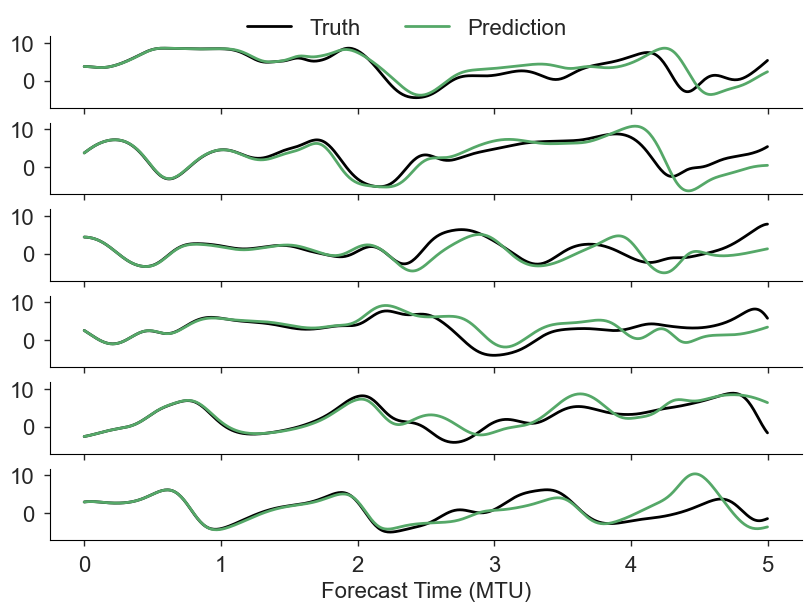

In [20]:
nrows = 6
fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows*1), constrained_layout=True, sharex=True, sharey=True)

for i, ax in enumerate(axs):
    xds["truth"].isel(x=i).plot(ax=ax, color="k", label="Truth")
    xds["prediction"].isel(x=i).plot(ax=ax, label="Prediction")
    ax.set(xlabel="", ylabel="", title="")
ax.set(xlabel="Forecast Time (MTU)")
axs[0].legend(loc=(.25,.85),ncol=2)

We can also look at the NRSE of the whole system as a function of time, as well as the NRMSE

In [21]:
se = (xds["prediction"] - xds["truth"])**2
nse = se / xds["truth"].std("ftime")
nrse = np.sqrt(nse)
nrmse = nrse.mean("x")

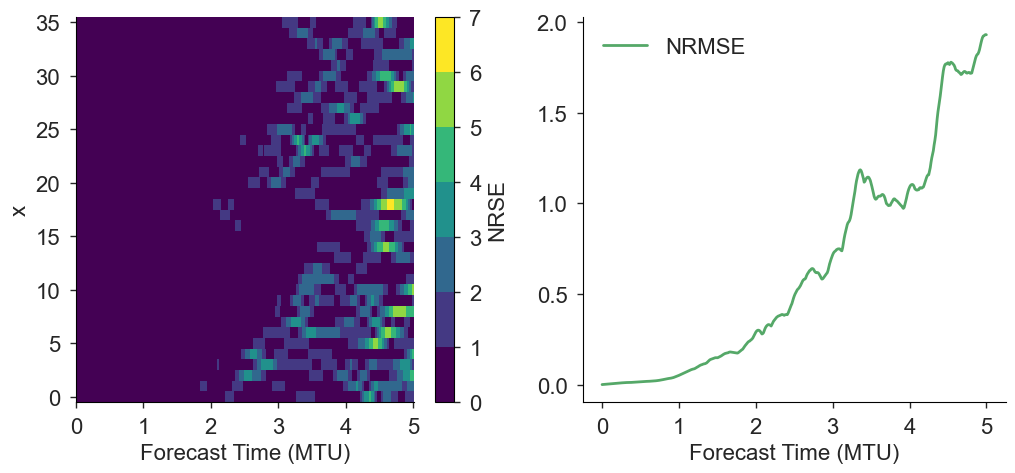

In [22]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

nrse.plot.pcolormesh(x="ftime", cbar_kwargs={"label":"NRSE"}, ax=axs[0], levels=8)
nrmse.plot(ax=axs[1], label="NRMSE")

axs[1].legend()
[ax.set(
    xlabel="Forecast Time (MTU)",
    xticks=np.arange(6),
) for ax in axs];

## Store the Trained Readout Weights

As with the standard ESN example.

In [23]:
eds = esn.to_xds()
eds.to_zarr("lazyesn-weights.zarr")

In [24]:
from xesn import from_zarr

In [25]:
esn2 = from_zarr("lazyesn-weights.zarr")

In [26]:
y2 = esn2.predict(tester, n_steps=500, n_spinup=500)
y2 = y2*scale + bias

In [27]:
np.abs(xds["prediction"]-y2).max().compute()

<xarray.DataArray ()>
array(3.92010691e-09)

## Cleanup

In [28]:
from shutil import rmtree

In [29]:
rmtree("lazyesn-weights.zarr")